# Import Packages

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pykrige
from pykrige.ok import OrdinaryKriging
from scipy.interpolate import Rbf, interp2d
import datetime
import gstools as gs
import geojsoncontour
import folium
from skgstat import Variogram
import warnings
import scipy
warnings.filterwarnings("ignore")

# Import Data

In [28]:
aqm_data = pd.read_csv("avg_aqm.csv")
aqm_data.columns

Index(['Unnamed: 0', 'sensor_id', 'longitude', 'latitude', 'airqualityindex',
       'relativehumidity', 'atmosphericpressure', 'co2', 'pm2p5', 'uv', 'o3',
       'airtemperature', 'no2', 'co', 'pm10', 'illuminance', 'so2',
       'ambientnoise'],
      dtype='object')

# Conditioning Data

In [29]:
lon = aqm_data.longitude.values
lat = aqm_data.latitude.values
val = aqm_data.airqualityindex.values

# Generate Grid Data for Interpolation

In [30]:
gridx = np.linspace(aqm_data.longitude.min()-0.02, aqm_data.longitude.max()+0.02, 200)
gridy = np.linspace(aqm_data.latitude.min()-0.02, aqm_data.latitude.max()+0.02, 200)

# Variogram Estimation

0.029579817041968427 3.7513888821021495 0


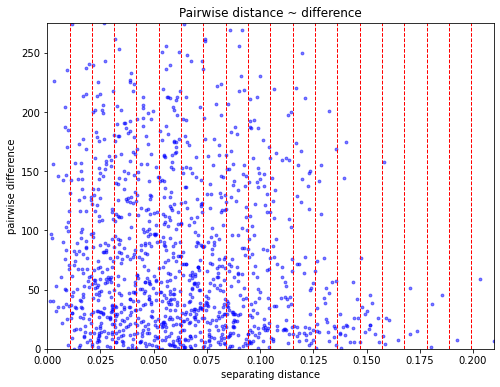

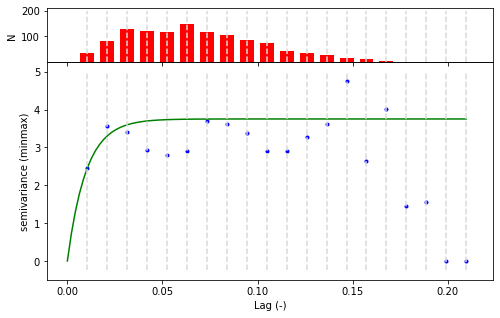

In [31]:
vario = Variogram(coordinates=aqm_data[["latitude", "longitude"]],
                  values=aqm_data["airqualityindex"],estimator='minmax',
                  n_lags=20, model='exponential',fit_sigma = 'sq',bin_func = 'even')
vario.distance_difference_plot()#.savefig('Distance_Variogram.png', dpi=300)
vario.plot(hist=True)#.savefig('Variogram.png', dpi=300)
print(vario.describe()["effective_range"],vario.describe()["sill"], vario.describe()["nugget"])

# Perform Ordinary Kriging

In [32]:
OK = OrdinaryKriging(
    np.array(lon),
    np.array(lat),
    val,
    variogram_model = "exponential",
    #variogram_parameters = {'sill': 3000, 'range': 0.025, 'nugget': 0},
    variogram_parameters = {'sill': vario.describe()["sill"], 'range': vario.describe()["effective_range"],
                            'nugget': vario.describe()["nugget"]},
    verbose = True,
    enable_plotting = False,
    coordinates_type = "geographic",
    exact_values = False,
    nlags = 20
)

Initializing variogram model...
Coordinates type: 'geographic' 

Using 'exponential' Variogram Model
Partial Sill: 3.7513888821021495
Full Sill: 3.7513888821021495
Range: 0.029579817041968427
Nugget: 0 

Calculating statistics on variogram model fit...


# Perform Interpolation

In [33]:
field, sigma_squared_p_krig = OK.execute("grid", gridx, gridy)

Executing Ordinary Kriging...



In [34]:
#field.data[field.data<0] = 0

# Plot Interpolated Field Data

Text(0.5, 1.0, 'Exponential Model Interpolation of Air Quality Index in Pune')

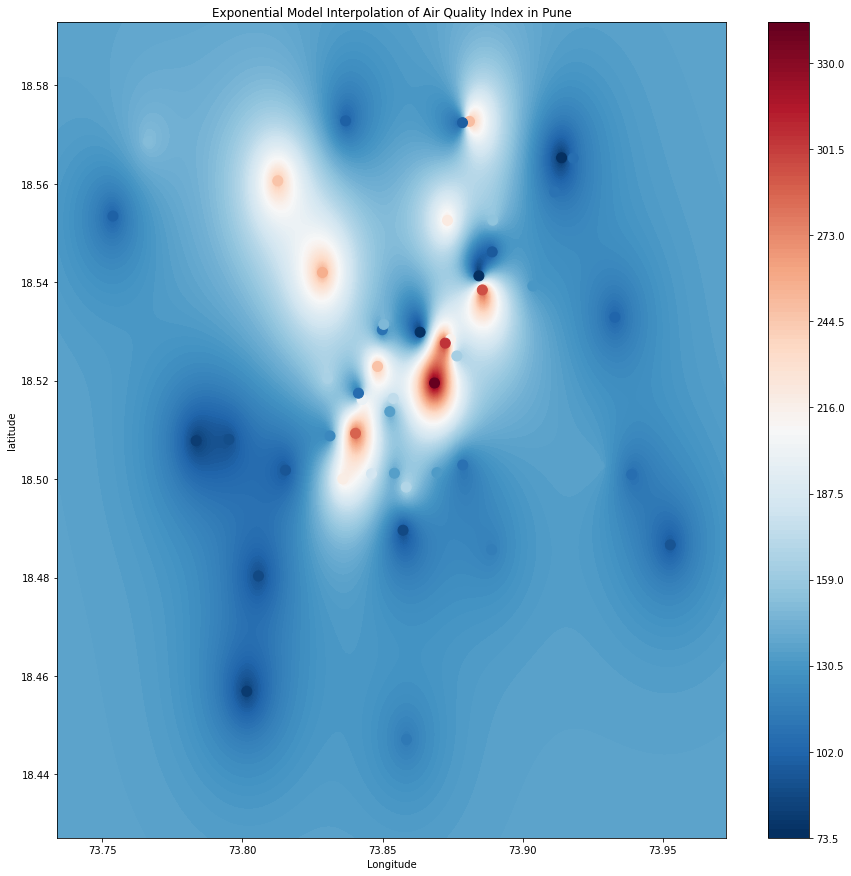

In [35]:
xintrp, yintrp = np.meshgrid(gridx, gridy) 
fig, ax = plt.subplots(figsize=(15,15))

#contour = plt.contourf(xintrp, yintrp, field,len(field),cmap=plt.cm.jet,alpha = 0.8)
contour = plt.contourf(xintrp, yintrp, field,len(field),cmap='RdBu_r',alpha = 1) #cmap = 'magma','RdBu_r','plt.cm.jet'
plt.clim(field.data.min(), field.data.max())
plt.colorbar(contour)
#npts = len(lon)
plt.scatter(lon, lat, 100, c = val, cmap='RdBu_r',alpha = 1)
plt.clim(val.min(), val.max())
plt.xlabel('Longitude')
plt.ylabel('latitude')
plt.title('Exponential Model Interpolation of Air Quality Index in Pune')
#plt.colorbar()
#plt.scatter(lon, lat,marker='o',c='b',s=npts)
#plt.savefig('AQI-Exponential-Kriging.png',dpi = 300)

In [36]:
# Convert matplotlib contourf to geojson
geojson = geojsoncontour.contourf_to_geojson(
    contourf=contour,
    min_angle_deg=2.0,
    ndigits=5,
    stroke_width=2,
    fill_opacity=0.6)

# Set up the map placeholdder
geomap = folium.Map([aqm_data.latitude.mean(), aqm_data.longitude.mean()], zoom_start=12, tiles="cartodbpositron")

# Plot the contour on Folium map
folium.GeoJson(
    geojson,
    style_function=lambda x: {
        'color':     x['properties']['stroke'],
        'weight':    x['properties']['stroke-width'],
        'fillColor': x['properties']['fill'],
        'opacity':   0.6,
    }).add_to(geomap)

In [37]:
geomap

# Splitting Data for Validating Accuracy

#### Create Training and Testing Data

In [38]:
msk = np.random.rand(len(aqm_data)) < 0.8
train = aqm_data[msk]
test = aqm_data[~msk]
print(len(train), len(test))

36 13


#### Conditioning Data

In [39]:
train_lon = train.longitude.values
train_lat = train.latitude.values
train_val = train.airqualityindex.values
test_lon = test.longitude.values
test_lat = test.latitude.values
test_val = test.airqualityindex.values

#### Variogram Estimation

0.027150180743436315 3.1197748959011156 0


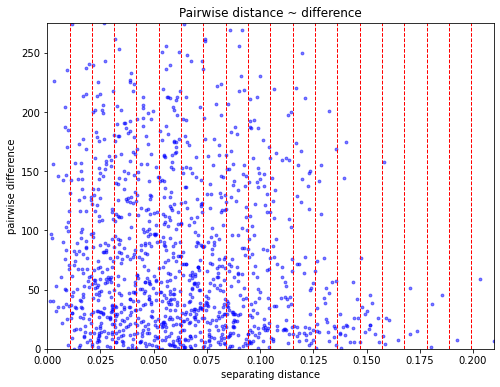

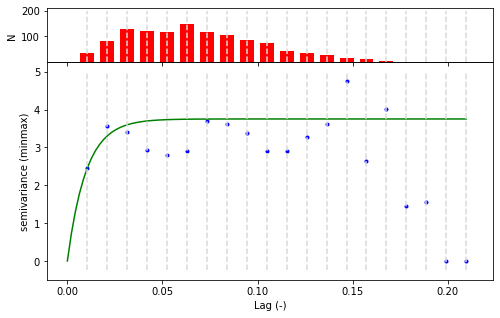

In [40]:
train_vario = Variogram(coordinates=train[["latitude", "longitude"]],
                  values=train["airqualityindex"], estimator='minmax',
                  n_lags=20, model='exponential',fit_sigma = 'sq',bin_func = 'even')
vario.distance_difference_plot()
vario.plot(hist=True)
print(train_vario.describe()["effective_range"],train_vario.describe()["sill"], train_vario.describe()["nugget"])

### Ordinary Kriging

In [41]:
train_OK = OrdinaryKriging(
    np.array(train_lon),
    np.array(train_lat),
    train_val,
    variogram_model = "exponential",
    #variogram_parameters = {'sill': 3000, 'range': 0.025, 'nugget': 0},
    variogram_parameters = {'sill': train_vario.describe()["sill"], 'range': train_vario.describe()["effective_range"],
                            'nugget': train_vario.describe()["nugget"]},
    verbose = True,
    enable_plotting = False,
    coordinates_type = "geographic",
    exact_values = False,
    nlags = 20
)

Initializing variogram model...
Coordinates type: 'geographic' 

Using 'exponential' Variogram Model
Partial Sill: 3.1197748959011156
Full Sill: 3.1197748959011156
Range: 0.027150180743436315
Nugget: 0 

Calculating statistics on variogram model fit...


### Perform Interpolation

In [42]:
train_field, train_sigma_squared_p_krig = train_OK.execute("grid", gridx, gridy)

Executing Ordinary Kriging...



### Plot Interpolated Data

Text(0.5, 1.0, 'Exponential Model Interpolation of Air Quality Index in Pune')

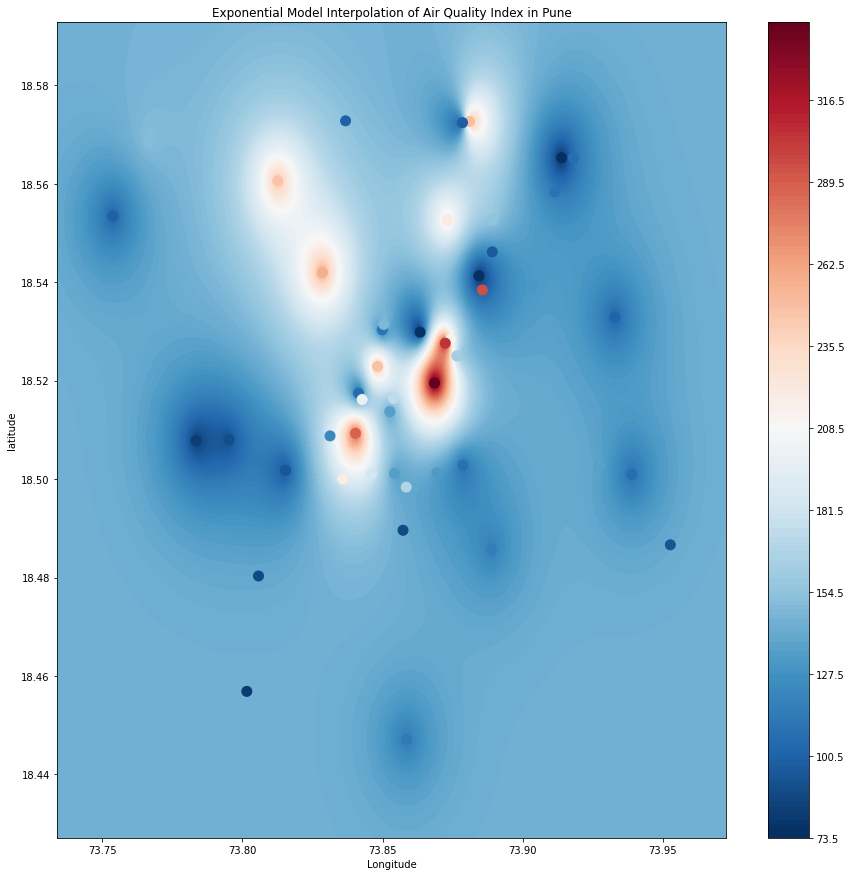

In [43]:
xintrp, yintrp = np.meshgrid(gridx, gridy) 
fig, ax = plt.subplots(figsize=(15,15))

#contour = plt.contourf(xintrp, yintrp, field,len(field),cmap=plt.cm.jet,alpha = 0.8)
contour = plt.contourf(xintrp, yintrp, train_field,len(train_field),cmap='RdBu_r',alpha = 1) #cmap = 'magma','RdBu_r',plt.cm.jet
plt.clim(train_field.data.min(), train_field.data.max())
plt.colorbar(contour)
#npts = len(lon)
plt.scatter(train_lon, train_lat, 100, c = train_val, cmap='RdBu_r',alpha = 1)
plt.clim(train_val.min(), train_val.max())
plt.scatter(test_lon, test_lat, 100, c = test_val, cmap='RdBu_r',alpha = 1)
plt.clim(train_val.min(), train_val.max())
plt.xlabel('Longitude')
plt.ylabel('latitude')
plt.title('Exponential Model Interpolation of Air Quality Index in Pune')
#plt.colorbar()
#plt.scatter(lon, lat,marker='o',c='b',s=npts)
#plt.savefig('AQI-Exponential-Kriging-Test-Train.png',dpi = 300)